# Training VGG16 based Encoder-Decoder

In [1]:
import time
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from ummon import *


from models.vgg_encoder_decoder import VGGNet, FCN8s
from utils.water_segmentation import Water
from utils import metrics, dataset_statistics

from matplotlib import pyplot as plt
import numpy as np

In [2]:
from utils.segmentation_analyzer import SegmentationAnalyzer
from utils.segmentation_trainer import SegmentationTrainer, SegmentationLogger
import json

def train(data_loader_trn, data_load_val, opt, model, epochs, path, additional_logger):
    
   
    
    loss = nn.BCEWithLogitsLoss()

    # training state
    trs = Trainingstate()

    #Additional logger
    seg_logger = additional_logger

    # optimizer
    #opt = optim.Adam(model.parameters(),lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=False)
    loss = nn.BCEWithLogitsLoss()

    with Logger(loglevel=10, logdir='.', log_batch_interval=20) as lg:
    
        # trainer
        trn = SegmentationTrainer(lg, model, loss, opt, trainingstate=trs, model_filename=path, 
                              combined_training_epochs=0, additional_logger=seg_logger)
    
        # train
        trn.fit(data_loader_trn, epochs=epochs, validation_set=data_loader_val, analyzer=SegmentationAnalyzer)
    
    
        ## evaluate on test set
        trs.load_weights_best_validation_(model)
        ev = SegmentationAnalyzer.evaluate(model, loss, data_loader_val, lg)
        lg.info("Performance on validation set: \nloss={:6.4f} \niou={:.4f} \nacc={:.4f} \nsensitivity={:.4f} \nspecificity={:.4f} \nprecision={:.4f} \nf1={:.4f}".format(
            ev["loss"], ev["iou"],ev["accuracy"], ev["sensitivity"], ev["specificity"], ev["precision"], ev["f1"]))

In [3]:
import matplotlib.pyplot as plt
def visualize_training(data):
    plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams['axes.xmargin'] = 0
    plt.plot(data["epoch_trn"], data["loss_trn"], label="training loss")
    plt.plot(data["epoch_trn"], data["loss_val"], label="validation loss")
    plt.xlabel('Epochen')
    plt.ylabel('BCE loss')
    plt.legend(loc='best')   
    plt.show()
    print("Minimum validation loss: {0:f} at epoch {1}".format(min(data["loss_val"]), data["loss_val"].index(min(data["loss_val"]))+1))
    print("Minimum training loss: {0:f} at epoch {1}".format(min(data["loss_trn"]), data["loss_trn"].index(min(data["loss_trn"]))+1))
    
    print("Maximum validation IoU: {0:f} at epoch {1}".format(max(data["iou_val"]), data["iou_val"].index(max(data["iou_val"]))+1))
    print("Maximum training IoU: {0:f} at epoch {1}".format(max(data["iou_trn"]), data["iou_trn"].index(max(data["iou_trn"]))+1))

# Training on "Tampere" Dataset only
### Configuration

In [28]:
batch_size = 4
identifier = 'VGG16_Enc_Dec_Tamp_RMS_lr_e-4'
directory = "../data/training_states/VGG16_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg_model = VGGNet(requires_grad=True, remove_fc=True, pretrained=True)
model = FCN8s(pretrained_net=vgg_model, n_class=1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])


### Dataset ###

In [29]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=['open','dock'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=['channel'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

400 images in training dataset
200 images in validation dataset


### Training ###

In [32]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, additional_logger = logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-34-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=Tru

Epoch: 12 - 00040/00100 - Loss: 0.00966. [ 28 s]
Epoch: 12 - 00060/00100 - Loss: 0.02639. [ 42 s]
Epoch: 12 - 00080/00100 - Loss: 0.01493. [ 56 s]
Epoch: 12 - 00100/00100 - Loss: 0.05470. [ 70 s]
Epoch: 12 - loss(trn/val):0.01090/0.10100, acc(val):97.54%, lr=0.00010. [70s] @5 samples/s 
Epoch: 13 - 00020/00100 - Loss: 0.00907. [ 14 s]
Epoch: 13 - 00040/00100 - Loss: 0.01662. [ 28 s]
Epoch: 13 - 00060/00100 - Loss: 0.01768. [ 42 s]
Epoch: 13 - 00080/00100 - Loss: 0.02049. [ 56 s]
Epoch: 13 - 00100/00100 - Loss: 0.00583. [ 70 s]
Epoch: 13 - loss(trn/val):0.00915/0.07873, acc(val):97.90%, lr=0.00010. [70s] @5 samples/s 
Epoch: 14 - 00020/00100 - Loss: 0.01253. [ 14 s]
Epoch: 14 - 00040/00100 - Loss: 0.00944. [ 28 s]
Epoch: 14 - 00060/00100 - Loss: 0.01187. [ 42 s]
Epoch: 14 - 00080/00100 - Loss: 0.01478. [ 56 s]
Epoch: 14 - 00100/00100 - Loss: 0.00845. [ 70 s]
Epoch: 14 - loss(trn/val):0.00909/0.07944, acc(val):97.83%, lr=0.00010. [70s] @5 samples/s 
Epoch: 15 - 00020/00100 - Loss: 0.0106

Epoch: 36 - 00080/00100 - Loss: 0.00613. [ 56 s]
Epoch: 36 - 00100/00100 - Loss: 0.00327. [ 70 s]
Epoch: 36 - loss(trn/val):0.00593/0.07215, acc(val):98.12%, lr=0.00010. [70s] @5 samples/s 
Epoch: 37 - 00020/00100 - Loss: 0.00501. [ 14 s]
Epoch: 37 - 00040/00100 - Loss: 0.02507. [ 28 s]
Epoch: 37 - 00060/00100 - Loss: 0.00768. [ 42 s]
Epoch: 37 - 00080/00100 - Loss: 0.01194. [ 56 s]
Epoch: 37 - 00100/00100 - Loss: 0.00513. [ 70 s]
Epoch: 37 - loss(trn/val):0.00637/0.07260, acc(val):98.03%, lr=0.00010. [70s] @5 samples/s 
Epoch: 38 - 00020/00100 - Loss: 0.00622. [ 14 s]
Epoch: 38 - 00040/00100 - Loss: 0.00635. [ 28 s]
Epoch: 38 - 00060/00100 - Loss: 0.00405. [ 42 s]
Epoch: 38 - 00080/00100 - Loss: 0.00885. [ 56 s]
Epoch: 38 - 00100/00100 - Loss: 0.00487. [ 70 s]
Epoch: 38 - loss(trn/val):0.00624/0.08715, acc(val):97.86%, lr=0.00010. [70s] @5 samples/s 
Epoch: 39 - 00020/00100 - Loss: 0.00579. [ 14 s]
Epoch: 39 - 00040/00100 - Loss: 0.00450. [ 28 s]
Epoch: 39 - 00060/00100 - Loss: 0.0057

Epoch: 60 - loss(trn/val):0.00497/0.07392, acc(val):98.33%, lr=0.00010. [70s] @5 samples/s 
Performance on validation set: 
loss=0.0638 
iou=0.9624 
acc=0.9825 
sensitivity=0.9754 
specificity=0.9881 
precision=0.9844 
f1=0.9797


#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

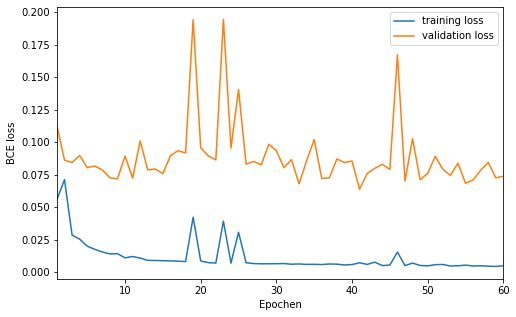

Minimum validation loss: 0.063837 at epoch 41
Minimum training loss: 0.004479 at epoch 59
Maximum validation IoU: 0.964449 at epoch 60
Maximum training IoU: 0.995732 at epoch 59


In [33]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Tamp_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Misc" Dataset only
### Configuration

In [34]:
batch_size = 4
identifier = 'VGG16_Enc_Dec_Misc_RMS_lr_e-4'
directory = "../data/training_states/VGG16_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [35]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg_model = VGGNet(requires_grad=True, remove_fc=True, pretrained=True)
model = FCN8s(pretrained_net=vgg_model, n_class=1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [36]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.MISC_TRAINING

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2188 images in training dataset
212 images in validation dataset


### Training ###

In [39]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-34-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=Tru

Epoch: 3 - 00420/00547 - Loss: 0.44393. [295 s]
Epoch: 3 - 00440/00547 - Loss: 0.37248. [309 s]
Epoch: 3 - 00460/00547 - Loss: 0.35536. [323 s]
Epoch: 3 - 00480/00547 - Loss: 0.32023. [337 s]
Epoch: 3 - 00500/00547 - Loss: 0.27145. [352 s]
Epoch: 3 - 00520/00547 - Loss: 0.20068. [366 s]
Epoch: 3 - 00540/00547 - Loss: 0.36009. [380 s]
Epoch: 3 - loss(trn/val):0.29251/0.33117, acc(val):85.64%, lr=0.00010 [BEST]. [385s] @5 samples/s 
Epoch: 4 - 00020/00547 - Loss: 0.18084. [ 14 s]
Epoch: 4 - 00040/00547 - Loss: 0.25227. [ 28 s]
Epoch: 4 - 00060/00547 - Loss: 0.20823. [ 42 s]
Epoch: 4 - 00080/00547 - Loss: 0.24483. [ 56 s]
Epoch: 4 - 00100/00547 - Loss: 0.70368. [ 70 s]
Epoch: 4 - 00120/00547 - Loss: 0.23175. [ 84 s]
Epoch: 4 - 00140/00547 - Loss: 0.24975. [ 98 s]
Epoch: 4 - 00160/00547 - Loss: 0.40613. [112 s]
Epoch: 4 - 00180/00547 - Loss: 0.25116. [126 s]
Epoch: 4 - 00200/00547 - Loss: 0.29199. [140 s]
Epoch: 4 - 00220/00547 - Loss: 0.24031. [154 s]
Epoch: 4 - 00240/00547 - Loss: 0.3415

Epoch: 9 - 00360/00547 - Loss: 0.17866. [253 s]
Epoch: 9 - 00380/00547 - Loss: 0.08167. [267 s]
Epoch: 9 - 00400/00547 - Loss: 0.79766. [281 s]
Epoch: 9 - 00420/00547 - Loss: 0.46279. [295 s]
Epoch: 9 - 00440/00547 - Loss: 0.20335. [309 s]
Epoch: 9 - 00460/00547 - Loss: 0.14648. [323 s]
Epoch: 9 - 00480/00547 - Loss: 0.43438. [337 s]
Epoch: 9 - 00500/00547 - Loss: 0.16821. [351 s]
Epoch: 9 - 00520/00547 - Loss: 0.37437. [365 s]
Epoch: 9 - 00540/00547 - Loss: 0.25510. [379 s]
Epoch: 9 - loss(trn/val):0.22473/0.28453, acc(val):87.98%, lr=0.00010 [BEST]. [384s] @5 samples/s 
Epoch: 10 - 00020/00547 - Loss: 0.24203. [ 14 s]
Epoch: 10 - 00040/00547 - Loss: 0.13960. [ 28 s]
Epoch: 10 - 00060/00547 - Loss: 0.25310. [ 42 s]
Epoch: 10 - 00080/00547 - Loss: 0.15462. [ 56 s]
Epoch: 10 - 00100/00547 - Loss: 0.28784. [ 70 s]
Epoch: 10 - 00120/00547 - Loss: 0.20787. [ 84 s]
Epoch: 10 - 00140/00547 - Loss: 0.24344. [ 98 s]
Epoch: 10 - 00160/00547 - Loss: 0.26402. [112 s]
Epoch: 10 - 00180/00547 - Los

Epoch: 15 - 00240/00547 - Loss: 0.33052. [168 s]
Epoch: 15 - 00260/00547 - Loss: 0.20227. [182 s]
Epoch: 15 - 00280/00547 - Loss: 0.15048. [196 s]
Epoch: 15 - 00300/00547 - Loss: 0.13026. [210 s]
Epoch: 15 - 00320/00547 - Loss: 0.11739. [224 s]
Epoch: 15 - 00340/00547 - Loss: 0.18122. [238 s]
Epoch: 15 - 00360/00547 - Loss: 0.09190. [252 s]
Epoch: 15 - 00380/00547 - Loss: 0.10094. [266 s]
Epoch: 15 - 00400/00547 - Loss: 0.25454. [281 s]
Epoch: 15 - 00420/00547 - Loss: 0.17725. [295 s]
Epoch: 15 - 00440/00547 - Loss: 0.12360. [309 s]
Epoch: 15 - 00460/00547 - Loss: 0.31328. [323 s]
Epoch: 15 - 00480/00547 - Loss: 0.13951. [337 s]
Epoch: 15 - 00500/00547 - Loss: 0.18966. [351 s]
Epoch: 15 - 00520/00547 - Loss: 0.34592. [365 s]
Epoch: 15 - 00540/00547 - Loss: 0.14785. [379 s]
Epoch: 15 - loss(trn/val):0.16402/0.27284, acc(val):89.01%, lr=0.00010. [384s] @5 samples/s 
Epoch: 16 - 00020/00547 - Loss: 0.15387. [ 14 s]
Epoch: 16 - 00040/00547 - Loss: 0.11714. [ 28 s]
Epoch: 16 - 00060/00547 -

Epoch: 21 - 00120/00547 - Loss: 0.14300. [ 84 s]
Epoch: 21 - 00140/00547 - Loss: 0.07653. [ 98 s]
Epoch: 21 - 00160/00547 - Loss: 0.09208. [112 s]
Epoch: 21 - 00180/00547 - Loss: 0.07456. [126 s]
Epoch: 21 - 00200/00547 - Loss: 0.10680. [140 s]
Epoch: 21 - 00220/00547 - Loss: 0.08468. [154 s]
Epoch: 21 - 00240/00547 - Loss: 0.09852. [168 s]
Epoch: 21 - 00260/00547 - Loss: 0.20213. [182 s]
Epoch: 21 - 00280/00547 - Loss: 0.24370. [197 s]
Epoch: 21 - 00300/00547 - Loss: 0.18501. [211 s]
Epoch: 21 - 00320/00547 - Loss: 0.08192. [225 s]
Epoch: 21 - 00340/00547 - Loss: 0.07276. [239 s]
Epoch: 21 - 00360/00547 - Loss: 0.18005. [253 s]
Epoch: 21 - 00380/00547 - Loss: 0.15476. [267 s]
Epoch: 21 - 00400/00547 - Loss: 0.12677. [281 s]
Epoch: 21 - 00420/00547 - Loss: 0.11000. [295 s]
Epoch: 21 - 00440/00547 - Loss: 0.06823. [309 s]
Epoch: 21 - 00460/00547 - Loss: 0.10714. [323 s]
Epoch: 21 - 00480/00547 - Loss: 0.15244. [337 s]
Epoch: 21 - 00500/00547 - Loss: 0.15112. [351 s]
Epoch: 21 - 00520/00

Epoch: 27 - 00020/00547 - Loss: 0.10922. [ 14 s]
Epoch: 27 - 00040/00547 - Loss: 0.11955. [ 28 s]
Epoch: 27 - 00060/00547 - Loss: 0.09750. [ 42 s]
Epoch: 27 - 00080/00547 - Loss: 0.30637. [ 56 s]
Epoch: 27 - 00100/00547 - Loss: 0.10188. [ 70 s]
Epoch: 27 - 00120/00547 - Loss: 0.08111. [ 84 s]
Epoch: 27 - 00140/00547 - Loss: 0.06259. [ 98 s]
Epoch: 27 - 00160/00547 - Loss: 0.14468. [112 s]
Epoch: 27 - 00180/00547 - Loss: 0.12727. [126 s]
Epoch: 27 - 00200/00547 - Loss: 0.05396. [140 s]
Epoch: 27 - 00220/00547 - Loss: 0.14213. [154 s]
Epoch: 27 - 00240/00547 - Loss: 0.15809. [168 s]
Epoch: 27 - 00260/00547 - Loss: 0.14563. [182 s]
Epoch: 27 - 00280/00547 - Loss: 0.16024. [196 s]
Epoch: 27 - 00300/00547 - Loss: 0.06378. [210 s]
Epoch: 27 - 00320/00547 - Loss: 0.11964. [224 s]
Epoch: 27 - 00340/00547 - Loss: 0.12898. [238 s]
Epoch: 27 - 00360/00547 - Loss: 0.04392. [252 s]
Epoch: 27 - 00380/00547 - Loss: 0.07773. [266 s]
Epoch: 27 - 00400/00547 - Loss: 0.09224. [280 s]
Epoch: 27 - 00420/00

Epoch: 32 - 00480/00547 - Loss: 0.07607. [336 s]
Epoch: 32 - 00500/00547 - Loss: 0.13654. [350 s]
Epoch: 32 - 00520/00547 - Loss: 0.04042. [365 s]
Epoch: 32 - 00540/00547 - Loss: 0.08666. [379 s]
Epoch: 32 - loss(trn/val):0.07604/0.50964, acc(val):84.40%, lr=0.00010. [383s] @5 samples/s 
Epoch: 33 - 00020/00547 - Loss: 0.06941. [ 14 s]
Epoch: 33 - 00040/00547 - Loss: 0.01926. [ 28 s]
Epoch: 33 - 00060/00547 - Loss: 0.04300. [ 42 s]
Epoch: 33 - 00080/00547 - Loss: 0.05414. [ 56 s]
Epoch: 33 - 00100/00547 - Loss: 0.06352. [ 70 s]
Epoch: 33 - 00120/00547 - Loss: 0.05240. [ 84 s]
Epoch: 33 - 00140/00547 - Loss: 0.02961. [ 98 s]
Epoch: 33 - 00160/00547 - Loss: 0.07153. [112 s]
Epoch: 33 - 00180/00547 - Loss: 0.06483. [126 s]
Epoch: 33 - 00200/00547 - Loss: 0.06873. [140 s]
Epoch: 33 - 00220/00547 - Loss: 0.05835. [154 s]
Epoch: 33 - 00240/00547 - Loss: 0.03870. [168 s]
Epoch: 33 - 00260/00547 - Loss: 0.02603. [182 s]
Epoch: 33 - 00280/00547 - Loss: 0.03479. [196 s]
Epoch: 33 - 00300/00547 -

Epoch: 38 - 00360/00547 - Loss: 0.07124. [252 s]
Epoch: 38 - 00380/00547 - Loss: 0.03747. [266 s]
Epoch: 38 - 00400/00547 - Loss: 0.03219. [280 s]
Epoch: 38 - 00420/00547 - Loss: 0.04469. [294 s]
Epoch: 38 - 00440/00547 - Loss: 0.09962. [308 s]
Epoch: 38 - 00460/00547 - Loss: 0.03234. [322 s]
Epoch: 38 - 00480/00547 - Loss: 0.04177. [336 s]
Epoch: 38 - 00500/00547 - Loss: 0.06606. [351 s]
Epoch: 38 - 00520/00547 - Loss: 0.04304. [365 s]
Epoch: 38 - 00540/00547 - Loss: 0.04354. [379 s]
Epoch: 38 - loss(trn/val):0.04774/0.51441, acc(val):86.14%, lr=0.00010. [384s] @5 samples/s 
Epoch: 39 - 00020/00547 - Loss: 0.06429. [ 14 s]
Epoch: 39 - 00040/00547 - Loss: 0.04149. [ 28 s]
Epoch: 39 - 00060/00547 - Loss: 0.04316. [ 42 s]
Epoch: 39 - 00080/00547 - Loss: 0.04082. [ 56 s]
Epoch: 39 - 00100/00547 - Loss: 0.04605. [ 70 s]
Epoch: 39 - 00120/00547 - Loss: 0.05786. [ 84 s]
Epoch: 39 - 00140/00547 - Loss: 0.04402. [ 98 s]
Epoch: 39 - 00160/00547 - Loss: 0.04598. [112 s]
Epoch: 39 - 00180/00547 -

Epoch: 44 - 00240/00547 - Loss: 0.07668. [168 s]
Epoch: 44 - 00260/00547 - Loss: 0.05753. [182 s]
Epoch: 44 - 00280/00547 - Loss: 0.04067. [196 s]
Epoch: 44 - 00300/00547 - Loss: 0.03016. [210 s]
Epoch: 44 - 00320/00547 - Loss: 0.02842. [224 s]
Epoch: 44 - 00340/00547 - Loss: 0.05435. [238 s]
Epoch: 44 - 00360/00547 - Loss: 0.04017. [252 s]
Epoch: 44 - 00380/00547 - Loss: 0.03881. [266 s]
Epoch: 44 - 00400/00547 - Loss: 0.03741. [280 s]
Epoch: 44 - 00420/00547 - Loss: 0.04682. [294 s]
Epoch: 44 - 00440/00547 - Loss: 0.07860. [308 s]
Epoch: 44 - 00460/00547 - Loss: 0.06052. [322 s]
Epoch: 44 - 00480/00547 - Loss: 0.07400. [336 s]
Epoch: 44 - 00500/00547 - Loss: 0.05908. [350 s]
Epoch: 44 - 00520/00547 - Loss: 0.02859. [364 s]
Epoch: 44 - 00540/00547 - Loss: 0.04605. [378 s]
Epoch: 44 - loss(trn/val):0.04053/0.45959, acc(val):87.63%, lr=0.00010. [383s] @5 samples/s 
Epoch: 45 - 00020/00547 - Loss: 0.06727. [ 14 s]
Epoch: 45 - 00040/00547 - Loss: 0.03103. [ 28 s]
Epoch: 45 - 00060/00547 -

Epoch: 50 - 00120/00547 - Loss: 0.01531. [ 84 s]
Epoch: 50 - 00140/00547 - Loss: 0.04420. [ 98 s]
Epoch: 50 - 00160/00547 - Loss: 0.02261. [112 s]
Epoch: 50 - 00180/00547 - Loss: 0.04450. [126 s]
Epoch: 50 - 00200/00547 - Loss: 0.02163. [140 s]
Epoch: 50 - 00220/00547 - Loss: 0.03291. [154 s]
Epoch: 50 - 00240/00547 - Loss: 0.02407. [168 s]
Epoch: 50 - 00260/00547 - Loss: 0.05486. [182 s]
Epoch: 50 - 00280/00547 - Loss: 0.04429. [196 s]
Epoch: 50 - 00300/00547 - Loss: 0.02181. [210 s]
Epoch: 50 - 00320/00547 - Loss: 0.03574. [224 s]
Epoch: 50 - 00340/00547 - Loss: 0.06162. [238 s]
Epoch: 50 - 00360/00547 - Loss: 0.02497. [252 s]
Epoch: 50 - 00380/00547 - Loss: 0.10853. [266 s]
Epoch: 50 - 00400/00547 - Loss: 0.02885. [280 s]
Epoch: 50 - 00420/00547 - Loss: 0.04301. [294 s]
Epoch: 50 - 00440/00547 - Loss: 0.02707. [308 s]
Epoch: 50 - 00460/00547 - Loss: 0.02490. [322 s]
Epoch: 50 - 00480/00547 - Loss: 0.02429. [336 s]
Epoch: 50 - 00500/00547 - Loss: 0.05388. [350 s]
Epoch: 50 - 00520/00

Epoch: 56 - 00020/00547 - Loss: 0.04438. [ 14 s]
Epoch: 56 - 00040/00547 - Loss: 0.15939. [ 28 s]
Epoch: 56 - 00060/00547 - Loss: 0.04000. [ 42 s]
Epoch: 56 - 00080/00547 - Loss: 0.03584. [ 56 s]
Epoch: 56 - 00100/00547 - Loss: 0.03792. [ 70 s]
Epoch: 56 - 00120/00547 - Loss: 0.02851. [ 84 s]
Epoch: 56 - 00140/00547 - Loss: 0.03657. [ 98 s]
Epoch: 56 - 00160/00547 - Loss: 0.03842. [112 s]
Epoch: 56 - 00180/00547 - Loss: 0.02196. [126 s]
Epoch: 56 - 00200/00547 - Loss: 0.05865. [140 s]
Epoch: 56 - 00220/00547 - Loss: 0.04555. [154 s]
Epoch: 56 - 00240/00547 - Loss: 0.02221. [168 s]
Epoch: 56 - 00260/00547 - Loss: 0.02149. [182 s]
Epoch: 56 - 00280/00547 - Loss: 0.02280. [196 s]
Epoch: 56 - 00300/00547 - Loss: 0.01385. [210 s]
Epoch: 56 - 00320/00547 - Loss: 0.03354. [224 s]
Epoch: 56 - 00340/00547 - Loss: 0.02165. [238 s]
Epoch: 56 - 00360/00547 - Loss: 0.02668. [252 s]
Epoch: 56 - 00380/00547 - Loss: 0.03813. [266 s]
Epoch: 56 - 00400/00547 - Loss: 0.01675. [280 s]
Epoch: 56 - 00420/00

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

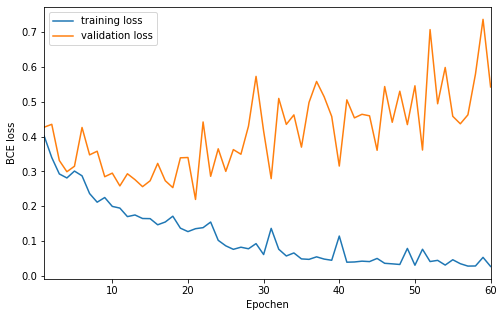

Minimum validation loss: 0.219207 at epoch 21
Minimum training loss: 0.026576 at epoch 60
Maximum validation IoU: 0.750683 at epoch 21
Maximum training IoU: 0.955246 at epoch 60


In [41]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Misc_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Tampere" and "Misc" Dataset
### Configuration

In [42]:
batch_size = 4
identifier = 'VGG16_Enc_Dec_Combined_RMS_lr_e-4_nopretrain'
directory = "../data/training_states/VGG16_Enc_Dec"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [43]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg_model = VGGNet(requires_grad=True, remove_fc=True, pretrained=False)
model = FCN8s(pretrained_net=vgg_model, n_class=1).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [44]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK_MISC_TRN

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=["open", "dock"], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(960,640))
dataset_val = Water('../data/WaterDataset', data_list_tamp=["channel"], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(960,640))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2588 images in training dataset
412 images in validation dataset


### Training ###

In [46]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-34-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
FCN8s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=Tru

Epoch: 3 - 00220/00647 - Loss: 0.36572. [154 s]
Epoch: 3 - 00240/00647 - Loss: 0.45881. [168 s]
Epoch: 3 - 00260/00647 - Loss: 0.54604. [182 s]
Epoch: 3 - 00280/00647 - Loss: 0.39471. [196 s]
Epoch: 3 - 00300/00647 - Loss: 0.30368. [210 s]
Epoch: 3 - 00320/00647 - Loss: 0.44547. [224 s]
Epoch: 3 - 00340/00647 - Loss: 0.40595. [238 s]
Epoch: 3 - 00360/00647 - Loss: 0.41890. [253 s]
Epoch: 3 - 00380/00647 - Loss: 0.34382. [267 s]
Epoch: 3 - 00400/00647 - Loss: 0.38209. [281 s]
Epoch: 3 - 00420/00647 - Loss: 0.34743. [295 s]
Epoch: 3 - 00440/00647 - Loss: 0.31978. [309 s]
Epoch: 3 - 00460/00647 - Loss: 0.34687. [323 s]
Epoch: 3 - 00480/00647 - Loss: 0.30825. [337 s]
Epoch: 3 - 00500/00647 - Loss: 0.41166. [351 s]
Epoch: 3 - 00520/00647 - Loss: 0.26553. [365 s]
Epoch: 3 - 00540/00647 - Loss: 0.63737. [379 s]
Epoch: 3 - 00560/00647 - Loss: 0.32200. [393 s]
Epoch: 3 - 00580/00647 - Loss: 0.32067. [407 s]
Epoch: 3 - 00600/00647 - Loss: 0.45874. [421 s]
Epoch: 3 - 00620/00647 - Loss: 0.29386. 

Epoch: 8 - 00240/00647 - Loss: 0.31739. [168 s]
Epoch: 8 - 00260/00647 - Loss: 0.41987. [182 s]
Epoch: 8 - 00280/00647 - Loss: 0.30399. [196 s]
Epoch: 8 - 00300/00647 - Loss: 0.34225. [210 s]
Epoch: 8 - 00320/00647 - Loss: 0.19662. [224 s]
Epoch: 8 - 00340/00647 - Loss: 0.45353. [238 s]
Epoch: 8 - 00360/00647 - Loss: 0.30677. [252 s]
Epoch: 8 - 00380/00647 - Loss: 0.14693. [267 s]
Epoch: 8 - 00400/00647 - Loss: 0.42408. [281 s]
Epoch: 8 - 00420/00647 - Loss: 0.29940. [295 s]
Epoch: 8 - 00440/00647 - Loss: 0.17727. [309 s]
Epoch: 8 - 00460/00647 - Loss: 0.34411. [323 s]
Epoch: 8 - 00480/00647 - Loss: 0.30481. [337 s]
Epoch: 8 - 00500/00647 - Loss: 0.24156. [351 s]
Epoch: 8 - 00520/00647 - Loss: 0.14545. [365 s]
Epoch: 8 - 00540/00647 - Loss: 0.35708. [379 s]
Epoch: 8 - 00560/00647 - Loss: 0.35057. [393 s]
Epoch: 8 - 00580/00647 - Loss: 0.30982. [407 s]
Epoch: 8 - 00600/00647 - Loss: 0.32243. [421 s]
Epoch: 8 - 00620/00647 - Loss: 0.14954. [435 s]
Epoch: 8 - 00640/00647 - Loss: 0.25891. 

Epoch: 13 - 00220/00647 - Loss: 0.39113. [154 s]
Epoch: 13 - 00240/00647 - Loss: 0.17796. [168 s]
Epoch: 13 - 00260/00647 - Loss: 0.13049. [182 s]
Epoch: 13 - 00280/00647 - Loss: 0.28464. [196 s]
Epoch: 13 - 00300/00647 - Loss: 0.16448. [210 s]
Epoch: 13 - 00320/00647 - Loss: 0.44472. [224 s]
Epoch: 13 - 00340/00647 - Loss: 0.39914. [238 s]
Epoch: 13 - 00360/00647 - Loss: 0.19682. [252 s]
Epoch: 13 - 00380/00647 - Loss: 0.41400. [266 s]
Epoch: 13 - 00400/00647 - Loss: 0.13079. [280 s]
Epoch: 13 - 00420/00647 - Loss: 0.16624. [294 s]
Epoch: 13 - 00440/00647 - Loss: 0.34850. [308 s]
Epoch: 13 - 00460/00647 - Loss: 0.07688. [322 s]
Epoch: 13 - 00480/00647 - Loss: 0.25680. [336 s]
Epoch: 13 - 00500/00647 - Loss: 0.28143. [351 s]
Epoch: 13 - 00520/00647 - Loss: 0.48886. [365 s]
Epoch: 13 - 00540/00647 - Loss: 0.34513. [379 s]
Epoch: 13 - 00560/00647 - Loss: 0.21086. [393 s]
Epoch: 13 - 00580/00647 - Loss: 0.29498. [407 s]
Epoch: 13 - 00600/00647 - Loss: 0.10881. [421 s]
Epoch: 13 - 00620/00

Epoch: 18 - 00180/00647 - Loss: 0.24749. [126 s]
Epoch: 18 - 00200/00647 - Loss: 0.12604. [140 s]
Epoch: 18 - 00220/00647 - Loss: 0.29820. [154 s]
Epoch: 18 - 00240/00647 - Loss: 0.22268. [168 s]
Epoch: 18 - 00260/00647 - Loss: 0.21999. [182 s]
Epoch: 18 - 00280/00647 - Loss: 0.28305. [196 s]
Epoch: 18 - 00300/00647 - Loss: 0.29014. [210 s]
Epoch: 18 - 00320/00647 - Loss: 0.41592. [224 s]
Epoch: 18 - 00340/00647 - Loss: 0.44275. [238 s]
Epoch: 18 - 00360/00647 - Loss: 0.40265. [252 s]
Epoch: 18 - 00380/00647 - Loss: 0.21684. [266 s]
Epoch: 18 - 00400/00647 - Loss: 0.25077. [280 s]
Epoch: 18 - 00420/00647 - Loss: 0.23962. [294 s]
Epoch: 18 - 00440/00647 - Loss: 0.10016. [308 s]
Epoch: 18 - 00460/00647 - Loss: 0.17221. [322 s]
Epoch: 18 - 00480/00647 - Loss: 0.17512. [336 s]
Epoch: 18 - 00500/00647 - Loss: 0.28374. [351 s]
Epoch: 18 - 00520/00647 - Loss: 0.22801. [365 s]
Epoch: 18 - 00540/00647 - Loss: 0.55614. [379 s]
Epoch: 18 - 00560/00647 - Loss: 0.14442. [393 s]
Epoch: 18 - 00580/00

Epoch: 23 - 00140/00647 - Loss: 0.18366. [ 98 s]
Epoch: 23 - 00160/00647 - Loss: 0.16562. [112 s]
Epoch: 23 - 00180/00647 - Loss: 0.21877. [126 s]
Epoch: 23 - 00200/00647 - Loss: 0.27964. [140 s]
Epoch: 23 - 00220/00647 - Loss: 0.20036. [154 s]
Epoch: 23 - 00240/00647 - Loss: 0.29323. [168 s]
Epoch: 23 - 00260/00647 - Loss: 0.26494. [182 s]
Epoch: 23 - 00280/00647 - Loss: 0.14378. [196 s]
Epoch: 23 - 00300/00647 - Loss: 0.22946. [210 s]
Epoch: 23 - 00320/00647 - Loss: 0.34484. [224 s]
Epoch: 23 - 00340/00647 - Loss: 0.14585. [238 s]
Epoch: 23 - 00360/00647 - Loss: 0.15469. [252 s]
Epoch: 23 - 00380/00647 - Loss: 0.22203. [266 s]
Epoch: 23 - 00400/00647 - Loss: 0.20435. [280 s]
Epoch: 23 - 00420/00647 - Loss: 1.04841. [294 s]
Epoch: 23 - 00440/00647 - Loss: 0.17250. [308 s]
Epoch: 23 - 00460/00647 - Loss: 0.25772. [322 s]
Epoch: 23 - 00480/00647 - Loss: 0.19569. [336 s]
Epoch: 23 - 00500/00647 - Loss: 0.11790. [350 s]
Epoch: 23 - 00520/00647 - Loss: 0.16706. [364 s]
Epoch: 23 - 00540/00

Epoch: 28 - 00100/00647 - Loss: 0.12954. [ 70 s]
Epoch: 28 - 00120/00647 - Loss: 0.07672. [ 84 s]
Epoch: 28 - 00140/00647 - Loss: 0.30443. [ 98 s]
Epoch: 28 - 00160/00647 - Loss: 0.28994. [112 s]
Epoch: 28 - 00180/00647 - Loss: 0.17212. [126 s]
Epoch: 28 - 00200/00647 - Loss: 0.12090. [140 s]
Epoch: 28 - 00220/00647 - Loss: 0.23584. [154 s]
Epoch: 28 - 00240/00647 - Loss: 0.32276. [168 s]
Epoch: 28 - 00260/00647 - Loss: 0.17597. [182 s]
Epoch: 28 - 00280/00647 - Loss: 0.26919. [196 s]
Epoch: 28 - 00300/00647 - Loss: 0.30627. [210 s]
Epoch: 28 - 00320/00647 - Loss: 0.20918. [224 s]
Epoch: 28 - 00340/00647 - Loss: 0.45909. [238 s]
Epoch: 28 - 00360/00647 - Loss: 0.13474. [252 s]
Epoch: 28 - 00380/00647 - Loss: 0.10934. [266 s]
Epoch: 28 - 00400/00647 - Loss: 0.20765. [280 s]
Epoch: 28 - 00420/00647 - Loss: 0.28250. [294 s]
Epoch: 28 - 00440/00647 - Loss: 0.16620. [308 s]
Epoch: 28 - 00460/00647 - Loss: 0.22199. [322 s]
Epoch: 28 - 00480/00647 - Loss: 0.12120. [336 s]
Epoch: 28 - 00500/00

Epoch: 33 - 00060/00647 - Loss: 0.14625. [ 42 s]
Epoch: 33 - 00080/00647 - Loss: 0.24584. [ 56 s]
Epoch: 33 - 00100/00647 - Loss: 0.18472. [ 70 s]
Epoch: 33 - 00120/00647 - Loss: 0.11951. [ 84 s]
Epoch: 33 - 00140/00647 - Loss: 0.08242. [ 98 s]
Epoch: 33 - 00160/00647 - Loss: 0.31104. [112 s]
Epoch: 33 - 00180/00647 - Loss: 0.11620. [126 s]
Epoch: 33 - 00200/00647 - Loss: 0.15536. [140 s]
Epoch: 33 - 00220/00647 - Loss: 0.20140. [154 s]
Epoch: 33 - 00240/00647 - Loss: 0.21708. [168 s]
Epoch: 33 - 00260/00647 - Loss: 0.08279. [182 s]
Epoch: 33 - 00280/00647 - Loss: 0.08311. [196 s]
Epoch: 33 - 00300/00647 - Loss: 0.14949. [210 s]
Epoch: 33 - 00320/00647 - Loss: 0.21359. [224 s]
Epoch: 33 - 00340/00647 - Loss: 0.07997. [238 s]
Epoch: 33 - 00360/00647 - Loss: 0.26072. [252 s]
Epoch: 33 - 00380/00647 - Loss: 0.15293. [266 s]
Epoch: 33 - 00400/00647 - Loss: 0.11660. [280 s]
Epoch: 33 - 00420/00647 - Loss: 0.16426. [294 s]
Epoch: 33 - 00440/00647 - Loss: 0.14960. [308 s]
Epoch: 33 - 00460/00

Epoch: 38 - 00020/00647 - Loss: 0.07476. [ 14 s]
Epoch: 38 - 00040/00647 - Loss: 0.13588. [ 28 s]
Epoch: 38 - 00060/00647 - Loss: 0.10778. [ 42 s]
Epoch: 38 - 00080/00647 - Loss: 0.04841. [ 56 s]
Epoch: 38 - 00100/00647 - Loss: 0.11020. [ 70 s]
Epoch: 38 - 00120/00647 - Loss: 0.05586. [ 84 s]
Epoch: 38 - 00140/00647 - Loss: 0.13025. [ 98 s]
Epoch: 38 - 00160/00647 - Loss: 0.08050. [112 s]
Epoch: 38 - 00180/00647 - Loss: 0.16844. [126 s]
Epoch: 38 - 00200/00647 - Loss: 0.19120. [140 s]
Epoch: 38 - 00220/00647 - Loss: 0.04416. [154 s]
Epoch: 38 - 00240/00647 - Loss: 0.12290. [168 s]
Epoch: 38 - 00260/00647 - Loss: 0.04420. [182 s]
Epoch: 38 - 00280/00647 - Loss: 0.05805. [196 s]
Epoch: 38 - 00300/00647 - Loss: 0.06388. [210 s]
Epoch: 38 - 00320/00647 - Loss: 0.63377. [224 s]
Epoch: 38 - 00340/00647 - Loss: 0.12113. [238 s]
Epoch: 38 - 00360/00647 - Loss: 0.15819. [252 s]
Epoch: 38 - 00380/00647 - Loss: 0.06799. [266 s]
Epoch: 38 - 00400/00647 - Loss: 0.11376. [280 s]
Epoch: 38 - 00420/00

Epoch: 42 - loss(trn/val):0.05704/0.31120, acc(val):90.71%, lr=0.00010. [453s] @5 samples/s 
Epoch: 43 - 00020/00647 - Loss: 0.01154. [ 14 s]
Epoch: 43 - 00040/00647 - Loss: 0.03823. [ 28 s]
Epoch: 43 - 00060/00647 - Loss: 0.04390. [ 42 s]
Epoch: 43 - 00080/00647 - Loss: 0.08294. [ 56 s]
Epoch: 43 - 00100/00647 - Loss: 0.04089. [ 70 s]
Epoch: 43 - 00120/00647 - Loss: 0.03966. [ 84 s]
Epoch: 43 - 00140/00647 - Loss: 0.07640. [ 98 s]
Epoch: 43 - 00160/00647 - Loss: 0.05770. [112 s]
Epoch: 43 - 00180/00647 - Loss: 0.06426. [126 s]
Epoch: 43 - 00200/00647 - Loss: 0.04681. [140 s]
Epoch: 43 - 00220/00647 - Loss: 0.10136. [154 s]
Epoch: 43 - 00240/00647 - Loss: 0.06661. [168 s]
Epoch: 43 - 00260/00647 - Loss: 0.06276. [182 s]
Epoch: 43 - 00280/00647 - Loss: 0.03717. [196 s]
Epoch: 43 - 00300/00647 - Loss: 0.07636. [210 s]
Epoch: 43 - 00320/00647 - Loss: 0.02872. [224 s]
Epoch: 43 - 00340/00647 - Loss: 0.10555. [238 s]
Epoch: 43 - 00360/00647 - Loss: 0.12027. [252 s]
Epoch: 43 - 00380/00647 -

Epoch: 47 - 00620/00647 - Loss: 0.04566. [434 s]
Epoch: 47 - 00640/00647 - Loss: 0.08994. [448 s]
Epoch: 47 - loss(trn/val):0.04288/0.40049, acc(val):90.71%, lr=0.00010. [453s] @5 samples/s 
Epoch: 48 - 00020/00647 - Loss: 0.12728. [ 14 s]
Epoch: 48 - 00040/00647 - Loss: 0.04394. [ 28 s]
Epoch: 48 - 00060/00647 - Loss: 0.12461. [ 42 s]
Epoch: 48 - 00080/00647 - Loss: 0.04703. [ 56 s]
Epoch: 48 - 00100/00647 - Loss: 0.04723. [ 70 s]
Epoch: 48 - 00120/00647 - Loss: 0.03506. [ 84 s]
Epoch: 48 - 00140/00647 - Loss: 0.19272. [ 98 s]
Epoch: 48 - 00160/00647 - Loss: 0.06013. [112 s]
Epoch: 48 - 00180/00647 - Loss: 0.04849. [126 s]
Epoch: 48 - 00200/00647 - Loss: 0.11815. [140 s]
Epoch: 48 - 00220/00647 - Loss: 0.03647. [154 s]
Epoch: 48 - 00240/00647 - Loss: 0.03660. [168 s]
Epoch: 48 - 00260/00647 - Loss: 0.04739. [182 s]
Epoch: 48 - 00280/00647 - Loss: 0.03194. [196 s]
Epoch: 48 - 00300/00647 - Loss: 0.04820. [210 s]
Epoch: 48 - 00320/00647 - Loss: 0.05999. [224 s]
Epoch: 48 - 00340/00647 -

Epoch: 52 - 00580/00647 - Loss: 0.09849. [406 s]
Epoch: 52 - 00600/00647 - Loss: 0.10333. [420 s]
Epoch: 52 - 00620/00647 - Loss: 0.01891. [434 s]
Epoch: 52 - 00640/00647 - Loss: 0.01801. [448 s]
Epoch: 52 - loss(trn/val):0.03646/0.31773, acc(val):91.21%, lr=0.00010. [453s] @5 samples/s 
Epoch: 53 - 00020/00647 - Loss: 0.02083. [ 14 s]
Epoch: 53 - 00040/00647 - Loss: 0.02018. [ 28 s]
Epoch: 53 - 00060/00647 - Loss: 0.01912. [ 42 s]
Epoch: 53 - 00080/00647 - Loss: 0.02369. [ 56 s]
Epoch: 53 - 00100/00647 - Loss: 0.02431. [ 70 s]
Epoch: 53 - 00120/00647 - Loss: 0.04557. [ 84 s]
Epoch: 53 - 00140/00647 - Loss: 0.04601. [ 98 s]
Epoch: 53 - 00160/00647 - Loss: 0.02027. [112 s]
Epoch: 53 - 00180/00647 - Loss: 0.03303. [126 s]
Epoch: 53 - 00200/00647 - Loss: 0.02779. [140 s]
Epoch: 53 - 00220/00647 - Loss: 0.30544. [154 s]
Epoch: 53 - 00240/00647 - Loss: 0.03007. [168 s]
Epoch: 53 - 00260/00647 - Loss: 0.03936. [182 s]
Epoch: 53 - 00280/00647 - Loss: 0.03979. [196 s]
Epoch: 53 - 00300/00647 -

Epoch: 57 - 00540/00647 - Loss: 0.02489. [378 s]
Epoch: 57 - 00560/00647 - Loss: 0.04163. [392 s]
Epoch: 57 - 00580/00647 - Loss: 0.03599. [406 s]
Epoch: 57 - 00600/00647 - Loss: 0.01799. [420 s]
Epoch: 57 - 00620/00647 - Loss: 0.02609. [434 s]
Epoch: 57 - 00640/00647 - Loss: 0.02775. [448 s]
Epoch: 57 - loss(trn/val):0.12344/0.61136, acc(val):85.47%, lr=0.00010. [453s] @5 samples/s 
Epoch: 58 - 00020/00647 - Loss: 0.02299. [ 14 s]
Epoch: 58 - 00040/00647 - Loss: 0.03738. [ 28 s]
Epoch: 58 - 00060/00647 - Loss: 0.01569. [ 42 s]
Epoch: 58 - 00080/00647 - Loss: 0.06283. [ 56 s]
Epoch: 58 - 00100/00647 - Loss: 0.01154. [ 70 s]
Epoch: 58 - 00120/00647 - Loss: 0.03861. [ 84 s]
Epoch: 58 - 00140/00647 - Loss: 0.05092. [ 98 s]
Epoch: 58 - 00160/00647 - Loss: 0.02726. [112 s]
Epoch: 58 - 00180/00647 - Loss: 0.04655. [126 s]
Epoch: 58 - 00200/00647 - Loss: 0.06970. [140 s]
Epoch: 58 - 00220/00647 - Loss: 0.04146. [154 s]
Epoch: 58 - 00240/00647 - Loss: 0.01368. [168 s]
Epoch: 58 - 00260/00647 -

#### Result: RMS | lr: 0.001 | wd: 0.00001 | momentum: 0 |

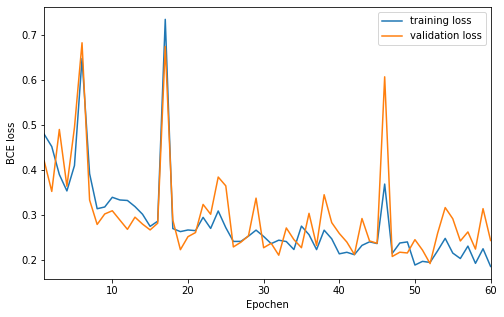

Minimum validation loss: 0.192059 at epoch 52
Minimum training loss: 0.185734 at epoch 60
Maximum validation IoU: 0.787174 at epoch 49
Maximum training IoU: 0.748221 at epoch 52


In [10]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Combined_RMS_lr_e-3" + "_learning_log.json"))
visualize_training(data)

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

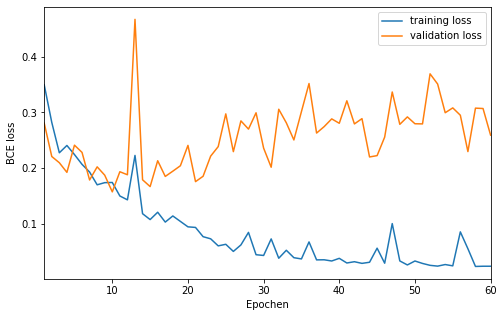

Minimum validation loss: 0.157316 at epoch 10
Minimum training loss: 0.023322 at epoch 58
Maximum validation IoU: 0.833989 at epoch 10
Maximum training IoU: 0.963927 at epoch 53


In [16]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Combined_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 | No pretrained model

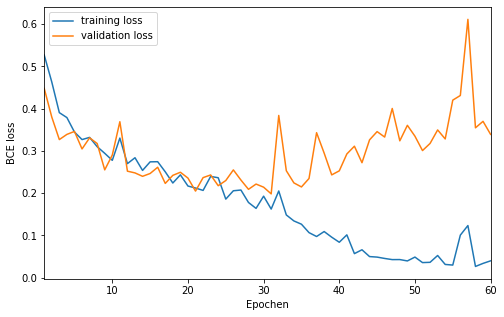

Minimum validation loss: 0.198435 at epoch 31
Minimum training loss: 0.026698 at epoch 58
Maximum validation IoU: 0.788740 at epoch 31
Maximum training IoU: 0.961875 at epoch 58


In [47]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Combined_RMS_lr_e-4_nopretrain" + "_learning_log.json"))
visualize_training(data)

#### Result: RMS | lr: 0.00001 | wd: 0.00001 | momentum: 0 |

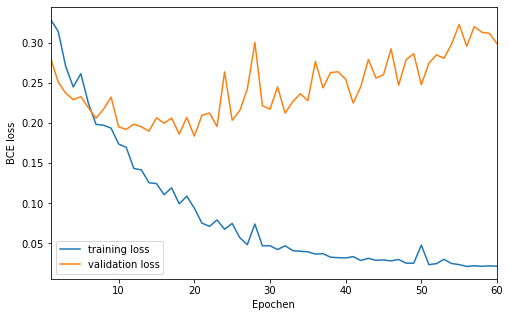

Minimum validation loss: 0.183844 at epoch 20
Minimum training loss: 0.021201 at epoch 56
Maximum validation IoU: 0.827626 at epoch 20
Maximum training IoU: 0.966320 at epoch 59


In [24]:
data = json.load(open(directory +"/VGG16_Enc_Dec_Combined_RMS_lr_e-5" + "_learning_log.json"))
visualize_training(data)